# RÉALISEZ UNE APPLICATION DE RECOMMANDATION DE CONTENU

<img src="mySaves/images/myContentLogo.png" alt="logo_myContent" width="400" class="center"/>

# SOMMAIRE

**Table of contents**<a id='toc0_'></a>    
- 0. [PRÉAMBULE](#toc3_)    
  - 0.1. [Imports](#toc3_1_)    
  - 0.2. [Le projet](#toc3_2_)    
  - 0.3. [Charger et explorer les données](#toc3_3_)    
    - 0.3.1. [Les fichiers à notre disposition](#toc3_3_1_)    
    - 0.3.2. [Les données *clicks*](#toc3_3_2_)    
      - 0.3.2.1. [Échantillon](#toc3_3_2_1_)    
      - 0.3.2.2. [Charger toutes les données *clicks*](#toc3_3_2_2_)    
      - 0.3.2.3. [La taille de la session `session_size`](#toc3_3_2_3_)    
      - 0.3.2.4. [Les données temporelles `session_start` et `click_timestamp`](#toc3_3_2_4_)    
      - 0.3.2.5. [Les identifiants `user_id`, `session_id`, `click_article_id`](#toc3_3_2_5_)    
        - 0.3.2.5.1. [Généralités](#toc3_3_2_5_1_)    
        - 0.3.2.5.2. [`click_articles_id` by `user_id`](#toc3_3_2_5_2_)    
        - 0.3.2.5.3. [Nombre de lectures des `click_articles_id` ?](#toc3_3_2_5_3_)    
    - 0.3.3. [Les données *articles_metadata*](#toc3_3_3_)    
      - 0.3.3.1. [Charger `articles_metadata` avec les bons dtypes](#toc3_3_3_1_)    
      - 0.3.3.2. [Filtrer `articles_metadata` sur les article lus](#toc3_3_3_2_)    
    - 0.3.4. [Le fichier d'*articles_embeddings*](#toc3_3_4_)    
      - 0.3.4.1. [Charger le fichier](#toc3_3_4_1_)    
      - 0.3.4.2. [Limiter la taille de l'embedding - `PCA`](#toc3_3_4_2_)    
- 1. [MODÉLISER GRÂCE AU *COLLABORATIVE FILTERING*](#toc4_)    
  - 1.1. [Construire un système de notation](#toc4_1_)    
  - 1.2. [Préparer le dataset pour `surprise`](#toc4_2_)    
  - 1.3. [Tester différents modèles](#toc4_3_)    
    - 1.3.1. [Probabilistic Matrix Factorization](#toc4_3_1_)    
    - 1.3.2. [Singular Value Decomposition](#toc4_3_2_)    
    - 1.3.3. [Singular Value Decomposition ++](#toc4_3_3_)    
    - 1.3.4. [Singular Value Decomposition ++ - GridSearch](#toc4_3_4_)    
    - 1.3.5. [Validation croisée - Bilan](#toc4_3_5_)    
  - 1.4. [Tester le modèle](#toc4_4_)    
  - 1.5. [Modèle plus léger pour le test de production](#toc4_5_)    
- 2. [MODÉLISATION *CONTENT BASE*](#toc5_)    
  - 3.1. [Préparer les données](#toc5_1_)    
  - 3.2. [Obtenir les catégories principales de l'utilisateur](#toc5_2_)    
  - 3.3. [Filtrer les embeddings sur les catégories principales](#toc5_3_)    
  - 3.4. [Obtenir 5 recommendations d'articles](#toc5_4_)    
  - 3.5. [Modèle final](#toc5_5_)    
  - 3.6. [Quel impact de la réduction ACP des *embeddings* initiaux sur les résultats ?](#toc5_6_)    
  - 3.7. [Modèle final léger pour le test en production](#toc5_7_)    
- 3. [MIXER LES DEUX TYPES DE RECOMMANDATION](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 0. <a id='toc3_'></a>[PRÉAMBULE](#toc0_)

## 0.1. <a id='toc3_1_'></a>[Imports](#toc0_)

Commençons par charger les librairies nécessaires :

In [22]:
# import necessary packages

# manipulate files
import os
from joblib import load, dump
# manipulate data
import pandas as pd
import numpy as np
# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
# custom functions
import myFunctions as mf
%load_ext autoreload
%autoreload 2
# datetime
import dateutil.relativedelta
import datetime
# collaborative filtering
from surprise import Reader, Dataset
from surprise import SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV, KFold
# content base
from sklearn.metrics.pairwise import cosine_similarity
# other tools
import time
import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# for requierements.txt
# pipreqs --force --ignore Patin_Clement_1_application_052024  --scan-notebooks

Créons un dossier pour nos sauvegardes :

In [24]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")

## 0.2. <a id='toc3_2_'></a>[Le projet](#toc0_)

Objectif: Développer un **MVP** (*Minimum Viable Product*) de système de recommandation pour **My Content**, permettant de recommander des articles et des livres pertinents aux utilisateurs.

**Solutions** à explorer :
- tester **differentes approches** de modélisation
- ***Collaborative Filtering*** - une technique de recommandation qui utilise les interactions d'utilisateurs avec des articles pour faire des suggestions
- ***Content Base*** - qui elle analyse les caractéristiques des articles eux-même pour faire des suggestions

**Données** à notre disposition :
- utilisation de données **open source** d'un portail d'informations contenant les intéractions d'utilisateurs avec des articles, ainsi que des informations sur les articles eux-mêmes
- https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom

**Système** de recommandation :
- dans cette phase amont du projet, développer un **outil simple**
- pour **un utilisateur** donné : recommander **5 articles**

**Application** :
- interface utilisateur simple
- input : liste d'utilisateurs, et plus exactement de `user_id`s
- output : liste de 5 `article_id`s recommandés

**Architecture du MVP** :
- occassion de mettre en oeuvre une solution **serverless**, avec ***Azure Functions***
- 2 propositions :
    - **solution 1** : 
        - backend : API classique déployée sur serveurs
        - frontend : UI classique déployée sur serveurs
        - lien entre les deux : *function app* qui appelle l'API et renvoie le résultat
    - **solution 2** :
        - backend : *function app*
        - frontend : UI classique déployée sur serveurs
- **Ici : nous pousserons la logique au maximum en gérant également l'UI grâce à *Azure Function***

**Architecture cible** :
- réfléchir à la suite : Quid de l'ajout de nouveaux utilisateurs ? de nouveaux articles ?
- **impact sur les solutions d'architectures ?**

## 0.3. <a id='toc3_3_'></a>[Charger et explorer les données](#toc0_)

### 0.3.1. <a id='toc3_3_1_'></a>[Les fichiers à notre disposition](#toc0_)

Les données représentent les intéractions avec des utilisateurs avec les articles disponibles. Elles sont organisées en plusieurs parties :
- **clicks** :
    - `clicks_sample.csv`
    - `clicks/` :
        - `clicks_hour_000.csv`
        - `clicks_hour_001.csv`
        - ...
        - `clicks_hour_383.csv`
        - `clicks_hour_384.csv`
- **articles** :
    - `articles_metadata.csv`
    - `articles_embeddings.pickle`

Préparons les chemins d'accès vers ces dossiers/fichiers :

In [25]:
# prepare paths
# parent path
parent_path = os.path.abspath("..")
# for 'clicks_sample"
clicks_sample_path = os.path.join(parent_path, "news-portal-user-interactions-by-globocom/clicks_sample.csv")
# for "clicks" directory
clicks_folder_path = os.path.join(parent_path, "news-portal-user-interactions-by-globocom/clicks")
# for "articles_metadata"
meta_path = os.path.join(parent_path, "news-portal-user-interactions-by-globocom/articles_metadata.csv")
# for "articles_embeddings"
emb_path = os.path.join(parent_path, "news-portal-user-interactions-by-globocom/articles_embeddings.pickle")


### 0.3.2. <a id='toc3_3_2_'></a>[Les données *clicks*](#toc0_)

#### 0.3.2.1. <a id='toc3_3_2_1_'></a>[Échantillon](#toc0_)

Regardons tout d'abord le fichier `clicks_sample.csv` :

In [26]:
# load clicks_sample in a dataframe
clicks_sample_df = pd.read_csv(clicks_sample_path)
clicks_sample_df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


Ce fichier est un échantillon et nous permet de comprendre les différentes features à notre disposition. Regardons chacune d'elle grâce à la fonction `myDescribe` :

In [27]:
# use custom function "myDescribe" on "clicks_sample_df"
mf.myDescribe(clicks_sample_df)

Output()

Les features sont décrites ici : https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=clicks_sample.csv

Ce que l'on peut en retenir :
- `user_id` : l'identifiant de l'utilisateur
- `session_id` : un identifiant donnée à la session dans laquelle le click a lieu. Tous les clicks d'une session d'utilisation ont donc le même identifiant
- `session_start` : horodatage du début de la session. De type *Unix time*, mais en **ms**
- `session_size` : nombre de clicks dans la session d'utilisation. Pour le fichier échantillon, compris entre 2 et 46.
- `click_article_id` : identifiant de l'article sur lequel le click a eu lieu
- `click_timestamp` : horodatage du click
- `click_environment` : environnement d'utilisation (`1` - *Facebook Instant Article*, `2` - *Mobile App*, `3` - *AMP (Accelerated Modile Pages)*, `4` - Web). Pour l'échantllon, la grande majorité des clicks ont eu lieu sur le site web.
- `click_deviceGroup` : type d'appareil utilisé (`1` - Tablette, `2` - télévision, `3` - vide (inconnu), `4` - smartphone, `5` - ordinateur de bureau)
- `click_os` : système d'exploitation de l'appareil. Peut être considérée comme catégorielle.
- `click_country` : identifiant donné au pays de l'utilisateur. La plupart des clicks ont été effectués depuis le pays 1.
- `click_region` : identifiant donné à la région de l'utilisateur
- `click_referrer_type` : inconnu

Mise à part `session_size`, `click_timestamp` et `session_start`, les colonnes peuvent être considérées comme catégorielles.

In [28]:
del clicks_sample_df
gc.collect()

4

#### 0.3.2.2. <a id='toc3_3_2_2_'></a>[Charger toutes les données *clicks*](#toc0_)

Chargeons maintenant l'ensemble des données `clicks_hour_xxx`. Pour cela nous avons rédigé une fonction `read_all_clicks` :

In [29]:
# create folder for saving
if not os.path.isdir("mySaves/dev_files"):
    os.mkdir("mySaves/dev_files")

In [30]:
# use custom function "read_all_clicks"
if "clicks_df.joblib" not in os.listdir("mySaves/dev_files") :
    clicks_df = mf.read_all_clicks(clicks_folder_path=clicks_folder_path, usecols = None, kept_user_ids = None)
    # save
    # clicks_df.to_csv(path_or_buf="mySaves/working_dfs/clicks_df.csv", index=False)
    dump(clicks_df, "mySaves/dev_files/clicks_df.joblib")
    
else :
    # load
    clicks_df = load("mySaves/dev_files/clicks_df.joblib")


#### 0.3.2.3. <a id='toc3_3_2_3_'></a>[La taille de la session `session_size`](#toc0_)

Regardons la distribution de `session_size` :

In [31]:
# create folder for saving
if not os.path.isdir("mySaves/images"):
    os.mkdir("mySaves/images")
if not os.path.isdir("mySaves/images/plots"):
    os.mkdir("mySaves/images/plots")

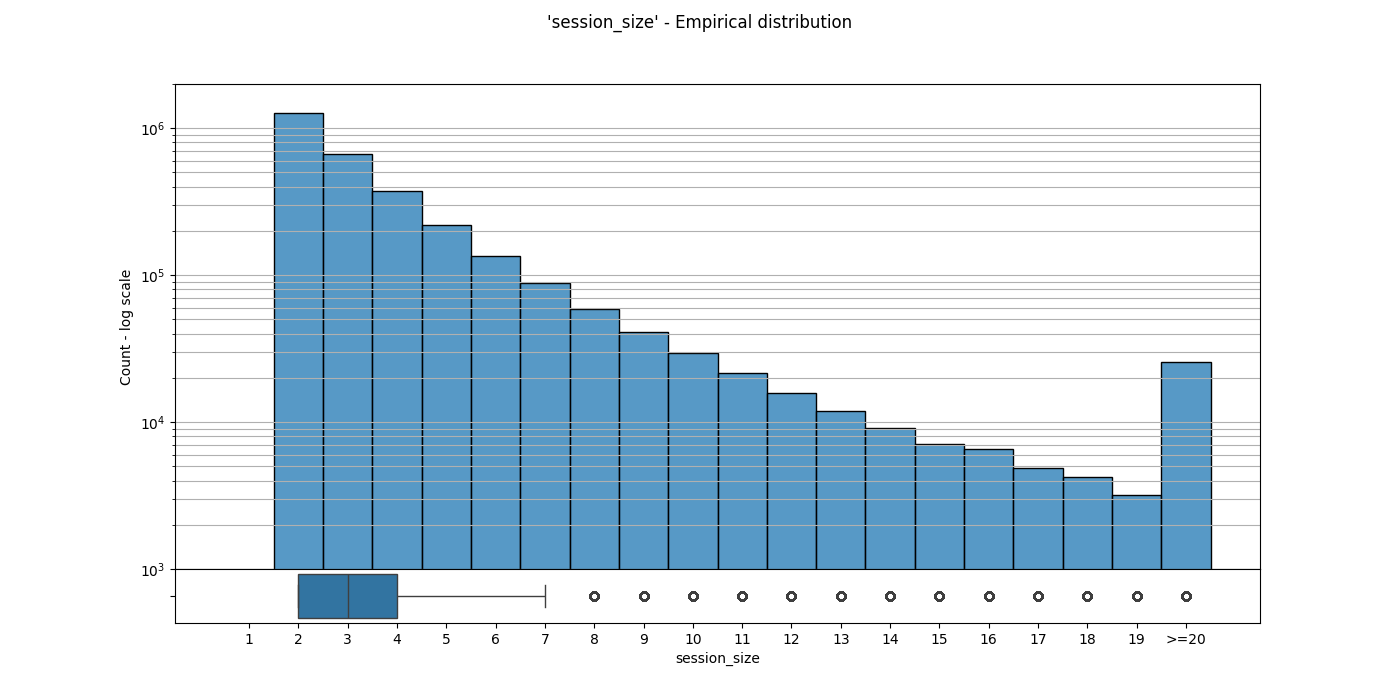

In [32]:
# plot distribution of "session_size"

if "distrib_session_size.png" not in os.listdir("mySaves/images/plots") :
    # create figure
    fig, (ax_hist, ax_box) = plt.subplots(2,1,figsize=(14,7), height_ratios=[0.9,0.1], sharex=True)

    # no space between plots
    plt.subplots_adjust(hspace=0)

    # clip values
    upper = 20
    session_size_clip = clicks_df["session_size"].clip(lower=0, upper=upper)

    ## boxplot

    sns.boxplot(x=session_size_clip, ax=ax_box)

    ## histogram

    # plot
    sns.histplot(session_size_clip, bins=upper, binrange=(0.5,upper+0.5), ax=ax_hist)

    # y logscale
    ax_hist.set_yscale("log")
    ax_hist.set_ylabel("Count - log scale")
    ax_hist.set_ylim(10**3,2*10**6)
    ax_hist.grid(True, axis="y", which='both')

    # x tick labels
    xticks = np.arange(1,upper+1)
    ax_hist.set_xticks(ticks=xticks, labels=[str(i) for i in xticks[:-1]]+[">="+str(upper)])
    ax_hist.tick_params(axis="x", bottom=False)

    # title
    fig.suptitle("'session_size' - Empirical distribution")

    fig.savefig(fname="mySaves/images/plots/distrib_session_size.png")

    plt.show()

else :
    # load image
    display(Image.open("mySaves/images/plots/distrib_session_size.png"))
    

Ce que l'on peut en retenir :
- il n'existe pas une seule session avec un click unique. Il s'agit peut-être d'un choix opéré par le créateur du dataset
- nous avons été contraint de tracer le graph avec une échelle logarithmique : la très grande majorité des sessions comporte peu de clicks

#### 0.3.2.4. <a id='toc3_3_2_4_'></a>[Les données temporelles `session_start` et `click_timestamp`](#toc0_)

Maintenant que ces features sont converties en type `datetime`, observons-les de nouveau :

In [33]:
# use custom function myDescribe on datetime features
mf.myDescribe(clicks_df[["session_start", "click_timestamp"]])

Output()

Ce que l'on peut retenir :
- les sessions de notre dataset ont démarré entre le 1er octobre et le 17 octobre 2017
- la grande majorité des clicks s'étale sur cette même période
- il y a cependant des clicks survenus bien après, jusqu'à 13 novembre...
- ces cas sont peu nombreux

Les temps de session après cette date doivent être alors anormalement élevés ? :

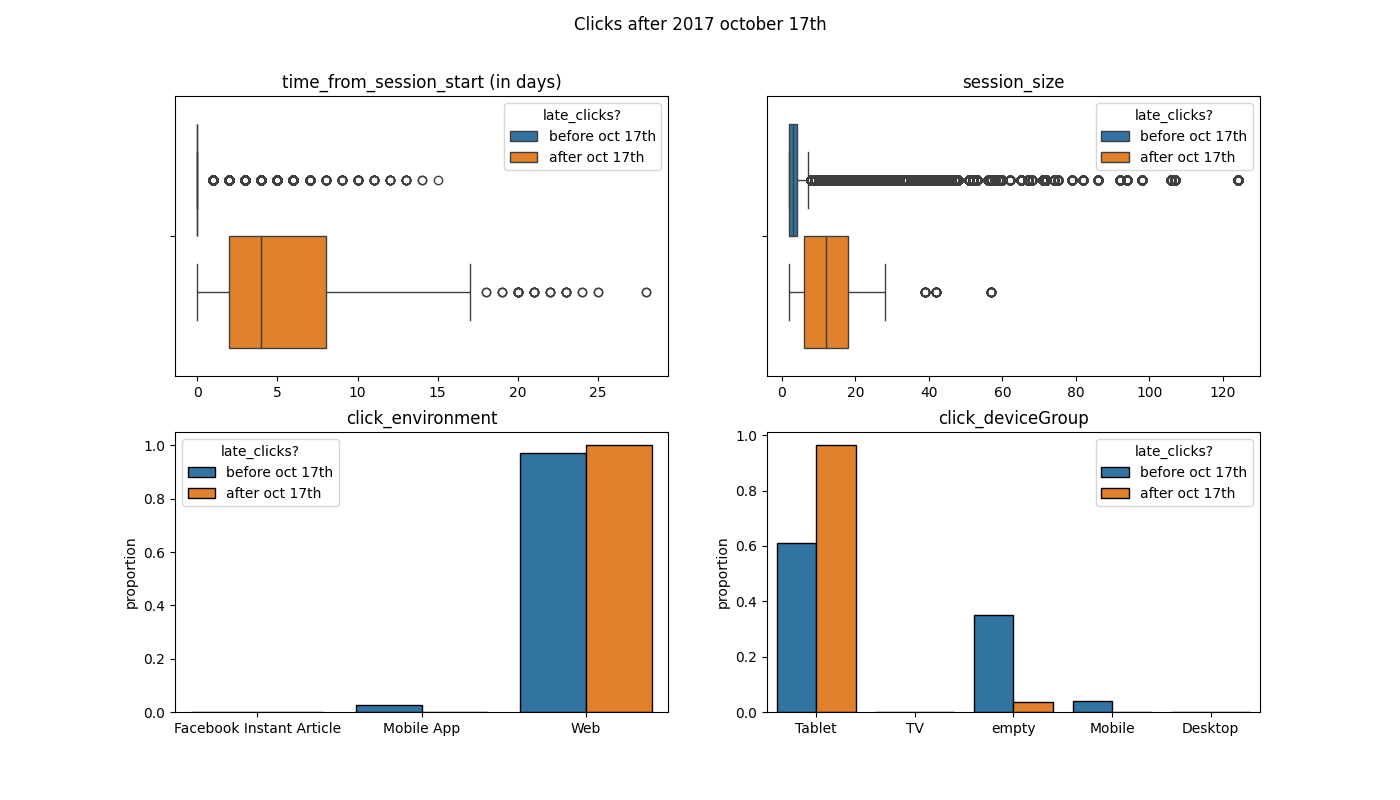

In [34]:
# explore clicks after october 17th

if "late_clicks_explore.png" not in os.listdir("mySaves/images/plots") :

    # make copy
    explore_late_clicks = clicks_df.copy()
    # compute time between the click and session start
    explore_late_clicks["time_from_session_start (in days)"] = (explore_late_clicks["click_timestamp"] - explore_late_clicks["session_start"]).dt.days
    # feature to tag clicks after october 17th
    explore_late_clicks["late_clicks?"] = explore_late_clicks["click_timestamp"].apply(lambda x : "after oct 17th" if x > datetime.datetime(year=2017, month=10, day=18) else "before oct 17th")
    explore_late_clicks=explore_late_clicks.sort_values("late_clicks?", ascending=False)

    ## plot "time_from_session_start", "session_size", "click_environment", "click_deviceGroup" distributions by "late_clicks?"

    # create figure
    fig, axs = plt.subplots(2,2, figsize=(14,8))
    axs = axs.flatten()

    # box plots for "time_from_session_start" and "session_size"
    sns.boxplot(data=explore_late_clicks, x="time_from_session_start (in days)", hue="late_clicks?", ax=axs[0])
    sns.boxplot(data=explore_late_clicks, x="session_size", hue="late_clicks?", ax=axs[1])

    # barplots for "click_environment" and "click_deviceGroup"
    for ax, col in zip([axs[2], axs[3]],["click_environment", "click_deviceGroup"]) :
        # create mask to filter "explore_late_clicks" by "late_clicks?"
        mask = explore_late_clicks["late_clicks?"] == "after oct 17th"
        # filter and "value_counts"
        late_prop = explore_late_clicks.loc[mask, col].value_counts(normalize=True).to_frame()
        late_prop["late_clicks?"] = "after oct 17th"
        casual_prop = explore_late_clicks.loc[~mask, col].value_counts(normalize=True).to_frame()
        casual_prop["late_clicks?"] = "before oct 17th"
        # concatenate
        prop = pd.concat([casual_prop, late_prop]).reset_index()
        # plot
        sns.barplot(data=prop, x=col, y="proportion", hue="late_clicks?", ax=ax, edgecolor="k")

    # titles
    for i,col in enumerate(["time_from_session_start (in days)", "session_size", "click_environment", "click_deviceGroup"]) :
        axs[i].set_title(col)
        axs[i].set_xlabel("")
    fig.suptitle("Clicks after 2017 october 17th")

    # save
    fig.savefig("mySaves/images/plots/late_clicks_explore.png")

    plt.show()

    del explore_late_clicks
    gc.collect()

else :
    # load image
    display(Image.open("mySaves/images/plots/late_clicks_explore.png"))

On voit effectivement que les **durées de sessions sont majoritairement plus élevées après le 17 octobre 2017**, date de la dernière session prise en compte dans le dataset.

On peut penser à un bug, ou bien à un navigateur resté ouvert.

On remarque en effet que, passée cette date, 100% de l'utilisation s'est faite sur la **page web** de l'application, en très grande majorité depuis une tablette. L'application ne doit pas déconnecter automatiquement l'utilisateur passé une certaine durée.

Nous ne prendrons donc **pas en compte la taille de la session `session_size`** dans notre projet sur la recommendation, celle-ci n'étant pas vraiment représentative de la réalité.

En revanche il pourrait être intéressant d'utiliser `click_timestamp` pour notre système de notation *Collaborative Filtering*. **Il serait en effet pertinent que le *rating* prennent en compte le degré d'ancienneté de la consommation du contenu**.

#### 0.3.2.5. <a id='toc3_3_2_5_'></a>[Les identifiants `user_id`, `session_id`, `click_article_id`](#toc0_)

##### 0.3.2.5.1. <a id='toc3_3_2_5_1_'></a>[Généralités](#toc0_)

Regardons les identifiants, qui pourront nous aider à contruire notre système de notation.

In [35]:
# use custom function myDescribe on id features
mf.myDescribe(clicks_df[["user_id", "session_id", "click_article_id"]])

Output()

Ce que l'on peut en retenir :
- `user_id` : certains utilisateurs sont très actifs
- `session_id` : certaines sessions sont très longues, ce qui est étonnant
- `click_article_id` : nous avons **46033 articles différents** lus par les utilisateurs

On peut combiner ces `id` et nous intéresser au nombre d'articles lus par utilisateur :
- combien ?
- certains ont-ils était lus plusieurs fois (plusieurs clicks) ?

##### 0.3.2.5.2. <a id='toc3_3_2_5_2_'></a>[`click_articles_id` by `user_id`](#toc0_)

In [41]:
# explore "click_df" by "user_id"

# create a dictionnary with aggregation functions
aggDict = {"click_article_id" : ["count", "nunique", mf.n_duplicates]}
# aggregate
clicks_by_uid = clicks_df.groupby(by="user_id", observed=True).agg(func=aggDict)
# handle columns names
clicks_by_uid.columns = [col[0]+"_BY_USER_"+col[1].upper() for col in clicks_by_uid.columns]
# use custom function myDescribe
mf.myDescribe(clicks_by_uid)

Output()

Ce que l'on peut en retenir :
- La grande majorité des utilisateurs ont lu moins de 10 articles
- Il y a cependant des utilisateurs très actifs qui perturbent la distribution. Il faudra **prendre garde à cela dans la construction de notre système de notation**
- Concernant les doublons, les utilisateurs ont, pour presque l'ensemble, logiquement lu chaque article une seule fois
- Certains ont cependant lu plusieurs fois certains articles. **Ce comportement mérite d'être étudié**

Regardons un exemple :

In [43]:
# filter "clicks_by_uid" on "N_DUPLICATES" == 209 (the max)
clicks_by_uid.loc[clicks_by_uid["click_article_id_BY_USER_N_DUPLICATES"]==209]

,click_article_id_BY_USER_COUNT,click_article_id_BY_USER_NUNIQUE,click_article_id_BY_USER_N_DUPLICATES
user_id,,,
2151,722,513,209
15867,900,691,209


Regardons par exemple l'utilisateur `2151`, sur ses 30 dernier clicks :

In [38]:
# filter on user 2151
clicks_df.loc[clicks_df.user_id == 2151].head(30)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
2915502,2151,1508174265282981,2017-10-16 17:17:45,5,87213,2017-10-16 23:13:45.152,Web,Tablet,17,1,21,7
2915501,2151,1508174265282981,2017-10-16 17:17:45,5,30409,2017-10-16 23:13:15.152,Web,Tablet,17,1,21,7
2915500,2151,1508174265282981,2017-10-16 17:17:45,5,292594,2017-10-16 23:11:52.712,Web,Tablet,17,1,21,7
2932356,2151,1508179555122841,2017-10-16 18:45:55,6,285433,2017-10-16 21:48:42.928,Web,Tablet,17,1,21,2
2932355,2151,1508179555122841,2017-10-16 18:45:55,6,206415,2017-10-16 21:48:12.928,Web,Tablet,17,1,21,2
2932354,2151,1508179555122841,2017-10-16 18:45:55,6,277107,2017-10-16 21:48:08.121,Web,Tablet,17,1,21,2
2932353,2151,1508179555122841,2017-10-16 18:45:55,6,158772,2017-10-16 21:47:42.758,Web,Tablet,17,1,21,2
2932352,2151,1508179555122841,2017-10-16 18:45:55,6,36162,2017-10-16 21:47:28.860,Web,Tablet,17,1,21,2
2915499,2151,1508174265282981,2017-10-16 17:17:45,5,109727,2017-10-16 20:19:16.477,Web,Tablet,17,1,21,7
2915498,2151,1508174265282981,2017-10-16 17:17:45,5,109752,2017-10-16 20:19:11.541,Web,Tablet,17,1,21,7


Ce que l'on observe :
- sachant que les clicks sont dans l'ordre, on observe que les **sessions sont entremêlées**. Cela pourrait venir de l'ouverture de plusieurs onglets ?
- il y a bien des doublons :
    - l'article `206415` apparaît 2 fois à presque 2 heures d'intervalle, dans 2 sessions différentes
    - l'article `277107` apparaît 3 fois à 1/2 heure et 6 heures d'intervalle, dans 3 sessions différentes
    - etc.
- les doublons n'apparaissent jamais au sein d'une même session, ce que l'on peut vérifier :

In [39]:
clicks_df.loc[clicks_df[["click_article_id","session_id"]].duplicated()]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type


Nous ne considérerons **pas ces doublons dans le système de notation** Collaborative Filtering, ce qui n'aurait pas vraiment de sens.

Mais alors chaque article se verra attribuer la même note ?

Pour éviter cela nous allons **pondérer** les notes **en fonction du niveau d'engagement des utilisateurs**. Nous considérons qu'un utilisateur moins consommateur de contenus a plus tendance à sélectionner avec soin. Dans le cas inverse, un utilisateur ultra actif n'est peut-être pas aller au bout des articles sur lesquels il a cliqué.

##### 0.3.2.5.3. <a id='toc3_3_2_5_3_'></a>[Nombre de lectures des `click_articles_id` ?](#toc0_)

On peut se demander également combien de fois les articles ont été lus ?

In [40]:
# explore the the number of times a article has been read
articles_counter = clicks_df["click_article_id"].value_counts().to_frame()
articles_counter.rename({"count":"numbers_of_occurrences"}, axis=1, inplace=True)
# use custum function myDescribe
mf.myDescribe(articles_counter)

Output()

L'écrasante majorité des articles n'ont été lus qu'un nombre limité de fois...
Regardons cela plus en détail :

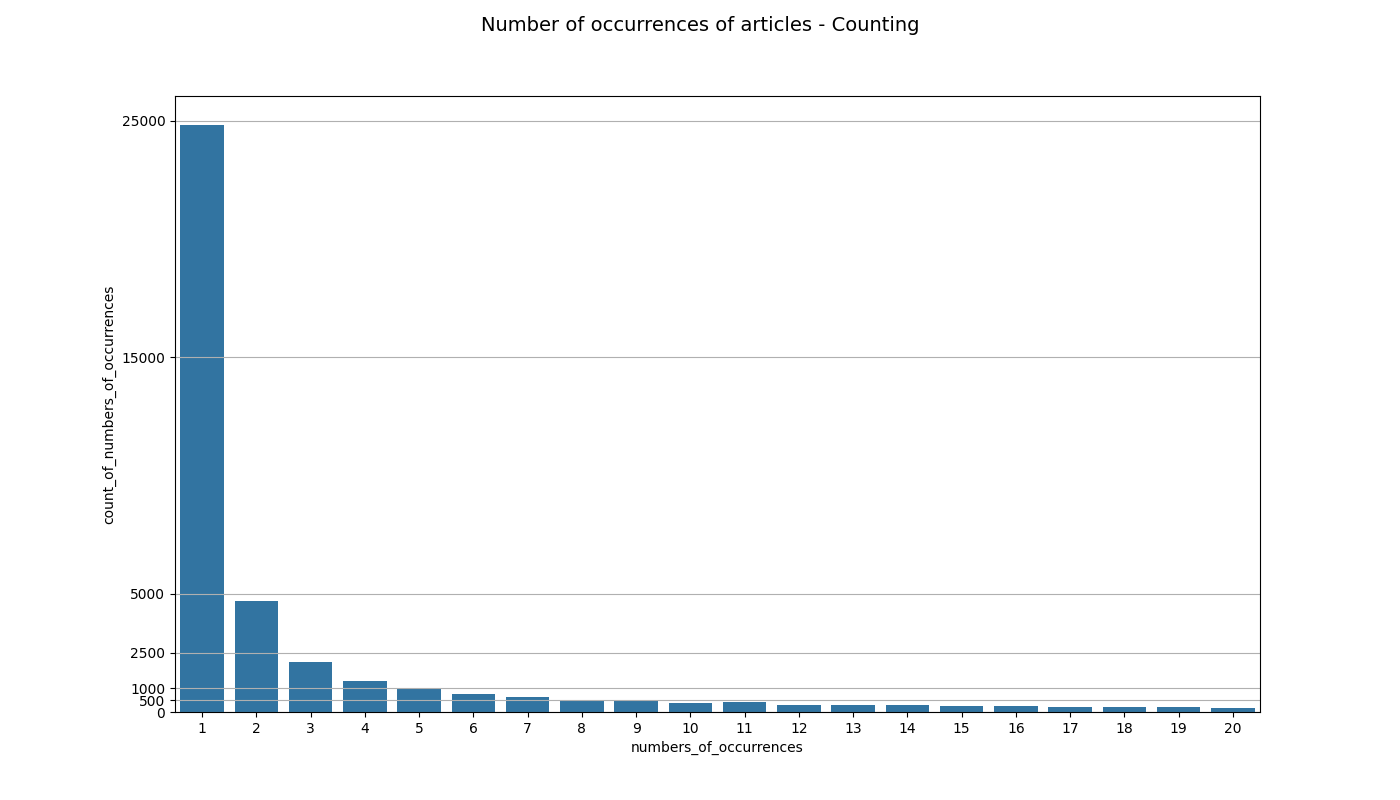

In [20]:
# counting occurrence numbers
count_of_numbers_of_occurrences = articles_counter.value_counts()
# rename Series
count_of_numbers_of_occurrences.name = "count_of_numbers_of_occurrences"
# reset index
count_of_numbers_of_occurrences = count_of_numbers_of_occurrences.reset_index()

# plot "count_of_numbers_of_occurrences" by "numbers_of_occurrences"
if "articles_count_of_numbers_of_occurrences.png" not in os.listdir("mySaves/images/plots") :
    # focus on first 20 "numbers_of_occurrences"
    count_of_numbers_of_occurrences = count_of_numbers_of_occurrences[:20]
    # create figure
    fig = plt.figure(figsize=(14, 8))
    # plot
    sns.barplot(data=count_of_numbers_of_occurrences, x="numbers_of_occurrences", y="count_of_numbers_of_occurrences")
    # adjust ticks
    plt.yticks(ticks=[0, 500, 1000, 2500, 5000, 15000, 25000])
    # show y grid
    plt.grid(visible=True, axis="y")
    # title
    fig.suptitle("Number of occurrences of articles - Counting", fontsize=14)
    # save image
    fig.savefig(fname="mySaves/images/plots/articles_count_of_numbers_of_occurrences.png")

    plt.show()

else :
    # load image
    display(Image.open("mySaves/images/plots/articles_count_of_numbers_of_occurrences.png"))

La **très forte prédominance** des articles avec très peu de vues pourrait **perturber la distribution des notations**, et donc un modèle de Collaborative Filtering.

De plus, et d'un manière plus générale, nous n'avons pas envie qu'un tel système propose à la lecture des articles n'ayant été lus que très peu de fois. Ce serait plus le rôle d'un modèle de type *Content Base*.

### 0.3.3. <a id='toc3_3_3_'></a>[Les données *articles_metadata*](#toc0_)

In [21]:
# load articles_metadata in a dataframe
meta_raw = pd.read_csv(meta_path)
meta_raw

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


Regardons chacune des features grâce à la fonction `myDescribe` :

In [22]:
# use custom function "myDescribe" on "meta_df"
mf.myDescribe(meta_raw)

Output()

Les features sont décrites ici : https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=clicks_sample.csv

Ce que l'on peut en retenir :
- `article_id` : l'identifiant de l'article, le même que `click_article_id`
- `category_id` : un identifiant donnée à la catégorie de l'article. 
- `created_at_ts` : horodatage de la rédaction de l'article. De type *Unix time*, mais en **ms**
- `publisher_id` : l'identifiant de l'éditeur. **Inutilisable** car ne comporte qu'une seule valeur.
- `words_count` : nombre de mots dans l'article

Mise à part `created_at_ts`, et `words_count`, les colonnes peuvent être considérées comme catégorielles.

In [23]:
# delete meta_raw
del meta_raw
gc.collect()

0

#### 0.3.3.1. <a id='toc3_3_3_1_'></a>[Charger `articles_metadata` avec les bons dtypes](#toc0_)

In [24]:
# use custom function to load and prepare "articles_metadata.csv"
meta_df = mf.read_meta(meta_path=meta_path)
# use custom function "myDescribe"
mf.myDescribe(meta_df)

Output()

Ce que l'on peut en retenir :
- `article_id` : 
    - il y a 364047 articles renseignés dans la base de données
    - pour rappel seul **46033 articles ont été lus à date par les utilisateurs**
- `words_count` : 
    - La majorité des articles comporte entre 150 et 250 mots
    - Il y a de rares articles beaucoup plus longs
- `created_at_ts` : 
    - les articles ont été créés entre 2005 et 2018
    - pour rappel le dernier click a été effectué en novembre 2017
    - vérifions la cohérence des dates sur les 46033 articles effectivement lus :


#### 0.3.3.2. <a id='toc3_3_3_2_'></a>[Filtrer `articles_metadata` sur les article lus](#toc0_)

Commençons par extraire la liste des `click_article_id` :

In [25]:
# extract unique "click_article_id"
unique_click_article_ids = clicks_df["click_article_id"].cat.categories

In [26]:
# filter meta_df
meta_df = meta_df.loc[meta_df["article_id"].isin(unique_click_article_ids)]

# use myDescribe
mf.myDescribe(meta_df)

Output()

Les dates de création d'article sont bien cohérentes : il n'y pas d'article de 2018.

### 0.3.4. <a id='toc3_3_4_'></a>[Le fichier d'*articles_embeddings*](#toc0_)

#### 0.3.4.1. <a id='toc3_3_4_1_'></a>[Charger le fichier](#toc0_)

Chargeons maintenant `articles_embeddings.pickle` :

In [27]:
# load articles_embeddings.pickle as a dataframe
embedding = pd.DataFrame(
    pd.read_pickle(emb_path),
)
embedding

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


On retrouve bien les 364047 articles référencés dans `articles_metadata`.

Nous nous servirons des embeddings pour comparer les articles les uns aux autres grâce à la `cosine_similarity`, afin de créer un modèle de recommandation de type Content Base.

#### 0.3.4.2. <a id='toc3_3_4_2_'></a>[Limiter la taille de l'embedding - `PCA`](#toc0_)

Afin de limiter l'impact en termes de mémoire, nous allons effectuer une ACP :

In [28]:
del embedding
gc.collect()

0

In [29]:
# create folder for saving
if not os.path.isdir("mySaves/prod_files"):
    os.mkdir("mySaves/prod_files")

In [30]:
# perform PCA on articles embeddings
if "emb_reduced.joblib" not in os.listdir("mySaves/prod_files") :
    # use custom function "embedding_reduction"
    emb_reduced = mf.embedding_reduction(
        emb_path=emb_path, 
        n_components=0.95, 
        articles_ids = None
        )
    # save
    dump(emb_reduced, "mySaves/prod_files/emb_reduced.joblib")
else :
    # load saved embeddings reduction
    emb_reduced = load("mySaves/prod_files/emb_reduced.joblib")

# 1. <a id='toc4_'></a>[MODÉLISER GRÂCE AU *COLLABORATIVE FILTERING*](#toc0_)

## 1.1. <a id='toc4_1_'></a>[Construire un système de notation](#toc0_)

Nous allons construire notre système de notation. Comme vu précédemment, celui-ci sera construit de la manière suivante :
- au préalable, nous supprimerons les **articles lus moins de 10 fois**. Ensuite,
- une première composante basée sur le fait que l'**utilisateur ait cliqué sur l'article** :
    - sans décompter les **doublons** (nous faisons l'hypothèse qu'un article n'est **réellement** lu qu'une fois par utilisateur)
    - normalisée par le **nombre d'articles différents lus par l'utilisateur**, pour avoir une note entre 0 et 1
- une seconde basée sur **l'"ancienneté" du click** :
    - qui mesure l'**éloignement du click depuis une date du référence**
    - normalisée par la **durée maximale**, pour avoir une note entre 0 et 1
    - la très grande majorité des intéractions ayant eu lieu avant le **18 octobre 2017**, nous prendrons cette date comme référence
- enfin, en prenant en compte la **popularité de l'article** :
    - nombre d'occurrences de l'article au global
    - normalisé pour avoir une note entre 0 et 1
    - nous considérons qu'un nombre d'occurences supérieur à 1000 suffit à obtenir la note maximale (bornage avec `clip`)

Nous testerons différentes manières de les combiner :

In [31]:
# use custom functions to create ratings
if "data_cf.joblib" not in os.listdir("mySaves/dev_files") :
    # create copy
    data_cf = clicks_df.copy()[["user_id", "click_article_id", "click_timestamp"]]

    # get rid of duplicates
    # we keep "last", the oldest 
    data_cf.drop_duplicates(subset=["user_id", "click_article_id"], inplace=True, keep="last")

    # delete articles that have been read less than 2 times
    article_counter = data_cf["click_article_id"].value_counts()
    article_counter_filtered = article_counter.loc[article_counter >= 10]
    mask = data_cf["click_article_id"].isin(article_counter_filtered.index)
    data_cf = data_cf.loc[mask]

    # create ratings using custom functions
    data_cf["seniority_rating"] = mf.my_seniority_rating (
        ts_series=data_cf["click_timestamp"], 
        ref_date=datetime.datetime(year=2017, month=10, day=18),
        min_seniority=0,
        max_seniority=None
        )

    data_cf["interaction_rating"] = mf.my_interaction_rating (
        user_series=data_cf["user_id"], 
        article_series=data_cf["click_article_id"]
        )
    
    data_cf["popularity_rating"] = mf.my_popularity_rating(
        article_series=data_cf["click_article_id"],
        min_count_for_best=1000
    )

    # test combinations
    data_cf["main_rating_MEAN"] = data_cf[["seniority_rating", "interaction_rating", "popularity_rating"]].mean(axis=1)
    data_cf["main_rating_GMEAN"] = (data_cf[["seniority_rating", "interaction_rating", "popularity_rating"]].prod(axis=1))**(1/3)
    from scipy import stats
    data_cf["main_rating_HMEAN"] = data_cf[["seniority_rating", "interaction_rating", "popularity_rating"]].apply(stats.hmean, axis=1)

    # save
    dump(data_cf, "mySaves/dev_files/data_cf.joblib")

else :
    #load
    data_cf = load("mySaves/dev_files/data_cf.joblib")

In [32]:
data_cf

,user_id,click_article_id,click_timestamp,seniority_rating,interaction_rating,popularity_rating,main_rating_MEAN,main_rating_GMEAN,main_rating_HMEAN
2957415,321209,95524,2017-10-22 17:08:20.862,1.0,0.500000,0.000059,0.500020,0.030827,0.000176
64352,22712,95524,2017-10-22 13:29:42.015,1.0,0.250000,0.000059,0.416686,0.024468,0.000176
2351058,108459,97039,2017-10-20 22:52:18.226,1.0,0.111111,0.000000,0.370370,0.000000,0.000000
2661808,268412,95524,2017-10-20 21:15:32.762,1.0,0.333333,0.000059,0.444464,0.026930,0.000176
2542492,38713,97039,2017-10-20 20:59:53.431,1.0,0.035714,0.000000,0.345238,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
187,70,119592,2017-10-01 03:00:18.863,0.0,0.250000,0.130628,0.126876,0.000000,0.000000
295,111,202436,2017-10-01 03:00:14.140,0.0,0.038462,0.004687,0.014383,0.000000,0.000000
399,154,96663,2017-10-01 03:00:04.207,0.0,0.022222,0.129662,0.050628,0.000000,0.000000
208,79,159359,2017-10-01 03:00:01.702,0.0,0.500000,0.005976,0.168659,0.000000,0.000000


Nous pouvons explorer ces notations :

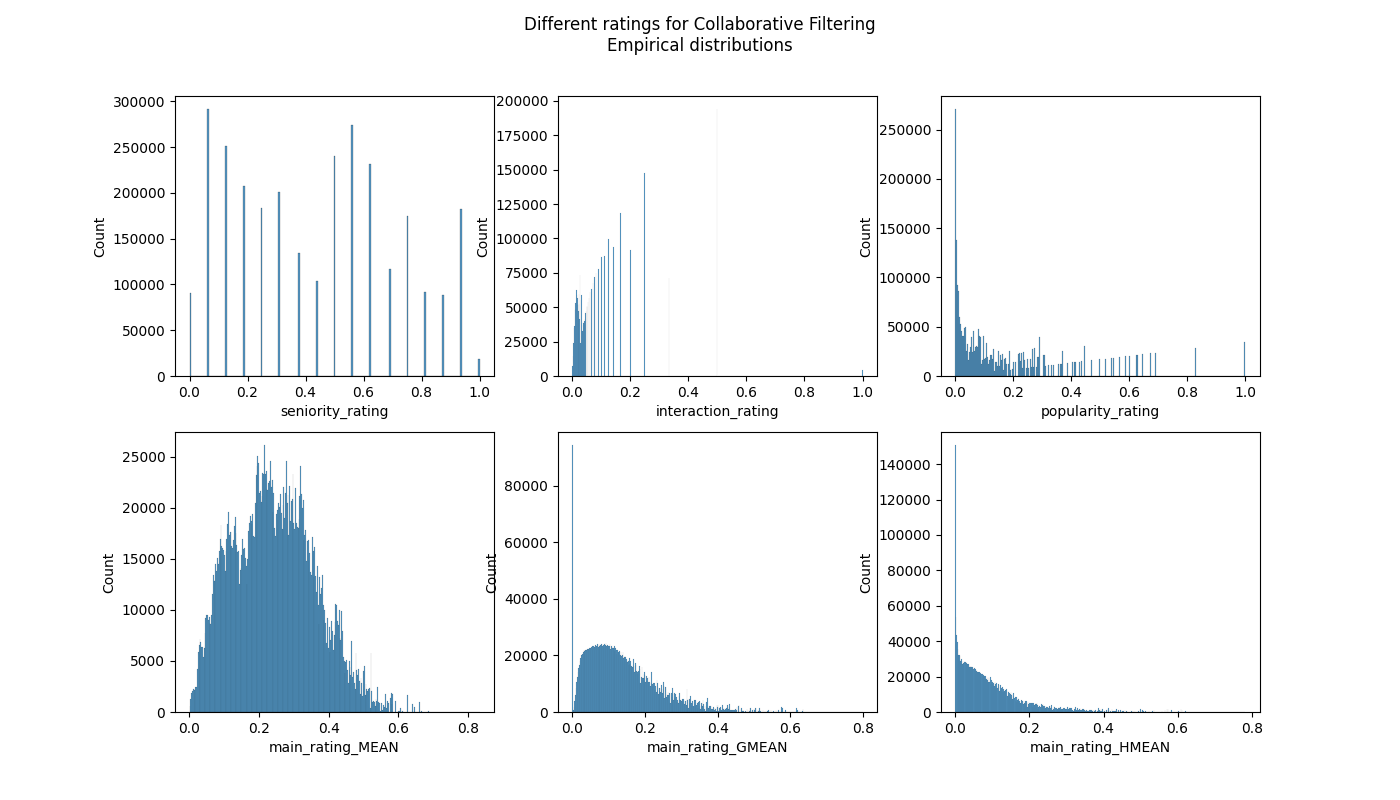

In [33]:
# explore "seniority_rating", "interaction_rating" and their combinations

if "cf_ratings_explore.png" not in os.listdir("mySaves/images/plots") :

    ## plot "seniority_rating", "interaction_rating" and their combinations

    # create figure
    fig, axs = plt.subplots(2,3, figsize=(14,8))
    axs = axs.flatten()

    # plot
    for i, col in enumerate(["seniority_rating", "interaction_rating", "popularity_rating", "main_rating_MEAN", "main_rating_GMEAN", "main_rating_HMEAN"]) :
        sns.histplot(data_cf[col], ax=axs[i])

    # title
    fig.suptitle("Different ratings for Collaborative Filtering\nEmpirical distributions")

    # save
    fig.savefig("mySaves/images/plots/cf_ratings_explore.png")

    plt.show()

else :
    # load image
    display(Image.open("mySaves/images/plots/cf_ratings_explore.png"))

Ce que l'on peut retenir de ces combinaisons :
- la moyenne classique arithmétique permet de "sauver" les observations où au moins une des trois composantes est non nulle
- les moyennes géométriques et harmonique permettent de pénaliser là où une composante est nulle
- la moyenne géométrique reste plus élevée que la moyenne harmonique

Nous retiendrons la moyenne géométrique.

In [34]:
# del useless dfs
del clicks_df, clicks_by_uid, meta_df, data_cf
gc.collect()

0

## 1.2. <a id='toc4_2_'></a>[Préparer le dataset pour `surprise`](#toc0_)

Nous pouvons maintenant créer notre dataframe qui servira de base pour le collaborative filtering avec la librairie `surprise` :

In [35]:
# use custom function to create a dataframe for surprise
if "X_cf.joblib" not in os.listdir("mySaves/dev_files") :
    X_cf = mf.read_clicks_and_prepare_rating(
        clicks_folder_path=clicks_folder_path, 
        ref_date_for_seniority=datetime.datetime(year=2017, month=10, day=18),
        kept_user_ids = None,
        min_seniority=0,
        max_seniority=None,
        minimum_count=10,
        min_count_for_best=1000
        )

    # save
    dump(X_cf, "mySaves/dev_files/X_cf.joblib")

else :
    # load
    X_cf = load("mySaves/dev_files/X_cf.joblib")

In [36]:
X_cf

,user_id,article_id,rating
0,321209,95524,0.030827
1,22712,95524,0.024468
2,108459,97039,0.000000
3,268412,95524,0.026930
4,38713,97039,0.000000
...,...,...,...
2883483,70,119592,0.000000
2883484,111,202436,0.000000
2883485,154,96663,0.000000
2883486,79,159359,0.000000


Nous allons créer un dataset `surprise` à partir de ce dataframe :

In [37]:
# create a surprise dataset

# create reader with rating scale from 0 to 1
reader = Reader(rating_scale=(0,1))

# create Dataset
X_cf_surprise = Dataset.load_from_df(X_cf, reader=reader)

Pour la sélection du modèle par validation croisée, nous fixons un `KFold` :

In [38]:
# create a KFold cross-validation iterator
cv = KFold(n_splits=5, random_state=16, shuffle=True)

## 1.3. <a id='toc4_3_'></a>[Tester différents modèles](#toc0_)

Nous allons tester différents modèles de Collaborative Filtering avec la librairie `surprise`. Initions un tableau pour stocker nos résultats :

In [39]:
# create a tab to save RMSE results
cf_results = pd.DataFrame(columns=["model_name", "parameters", "mean_RMSE_CV", "mean_training_time_CV"])

In [40]:
# create folder for saving
if not os.path.isdir("mySaves/cf_results"):
    os.mkdir("mySaves/cf_results")

### 1.3.1. <a id='toc4_3_1_'></a>[Probabilistic Matrix Factorization](#toc0_)

Testons d'abord le modèle `SVD` avec `biased = False`, équivalent au modèle `Probabilistic Matrix Factorization` :

In [41]:
if "PMF_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVD(biased=False)
    # cross validation
    results = cross_validate(algo=model, data=X_cf_surprise, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/PMF_results.joblib")
else :
    # load
    results = load("mySaves/cf_results/PMF_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "PMF",
    dict(n_factors=100, n_epochs=20, biased=False, lr_all=0.005, reg_all=0.02),
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

In [42]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.166966,20.834293


### 1.3.2. <a id='toc4_3_2_'></a>[Singular Value Decomposition](#toc0_)

Testons maintenant le modèle `SVD` avec `biased = True` :

In [43]:
if "SVD_raw_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVD(biased=True)
    # cross validation
    results = cross_validate(algo=model, data=X_cf_surprise, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/SVD_raw_results.joblib")
else :
    # load
    results = load("mySaves/cf_results/SVD_raw_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "SVD_raw",
    dict(n_factors=100, n_epochs=20, biased=True, lr_all=0.005, reg_all=0.02),
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

In [44]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.166966,20.834293
1,SVD_raw,"{'n_factors': 100, 'n_epochs': 20, 'biased': T...",0.091023,20.371960


### 1.3.3. <a id='toc4_3_3_'></a>[Singular Value Decomposition ++](#toc0_)

Testons maintenant le modèle `SVDpp` :

In [45]:
if "SVDpp_raw_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVDpp()
    # cross validation
    results = cross_validate(algo=model, data=X_cf_surprise, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/SVDpp_raw_results.joblib")
    del model
    gc.collect()
else :
    # load
    results = load("mySaves/cf_results/SVDpp_raw_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "SVDpp_raw",
    dict(n_factors=20, n_epochs=20, lr_all=0.007, reg_all=0.02),
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

In [46]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.166966,20.834293
1,SVD_raw,"{'n_factors': 100, 'n_epochs': 20, 'biased': T...",0.091023,20.371960
2,SVDpp_raw,"{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0....",0.089499,112.141973


Le résultat est meilleur.

### 1.3.4. <a id='toc4_3_4_'></a>[Singular Value Decomposition ++ - GridSearch](#toc0_)

Essayons d'optimiser le modèle avec une recherche sur grille :

In [47]:
param_grid = {
    'n_factors': [100, 120],
    'n_epochs': [20, 30],
    'lr_all': [0.001, 0.003]
    }

In [48]:
if "SVDpp_gs_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate grid search
    gs = GridSearchCV(
        algo_class=SVDpp,
        param_grid=param_grid,
        measures=["rmse"],
        cv=cv,
        refit=False,
        n_jobs=-5,
        joblib_verbose=10,
        pre_dispatch='1*n_jobs'
    )
    # fit
    gs.fit(X_cf_surprise)
    # results
    gs_results = pd.DataFrame(gs.cv_results)
    gs_params = gs.best_params["rmse"]
    # save
    dump(gs_results, "mySaves/cf_results/SVDpp_gs_results.joblib")
    dump(gs_params, "mySaves/cf_results/SVDpp_gs_params.joblib")

    del gs
    gc.collect()
else :
    # load
    gs_results = load("mySaves/cf_results/SVDpp_gs_results.joblib")
    gs_params = load("mySaves/cf_results/SVDpp_gs_params.joblib")

# top 5 results
gs_results.sort_values(by="mean_test_rmse").head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all
2,0.080782,0.080898,0.080973,0.081050,0.080955,0.080932,0.000089,1,1202.435779,17.436806,55.266531,8.206510,"{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0...",100,30,0.001
6,0.082519,0.082577,0.082615,0.082737,0.082552,0.082600,0.000075,2,1478.495026,17.185579,43.368909,6.530638,"{'n_factors': 120, 'n_epochs': 30, 'lr_all': 0...",120,30,0.001
3,0.084313,0.084524,0.084459,0.084727,0.084490,0.084503,0.000133,3,1222.368533,2.714303,61.718657,1.998164,"{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0...",100,30,0.003
7,0.085255,0.085390,0.085330,0.085475,0.085363,0.085362,0.000072,4,1116.262824,174.191342,20.222834,5.111737,"{'n_factors': 120, 'n_epochs': 30, 'lr_all': 0...",120,30,0.003
0,0.086372,0.086552,0.086524,0.086569,0.086387,0.086481,0.000084,5,792.417765,3.212068,47.887406,0.834547,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.001


In [49]:
if "SVDpp_opti_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVDpp(**gs_params)
    # cross validation
    results = cross_validate(algo=model, data=X_cf_surprise, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/SVDpp_opti_results.joblib")
else :
    # load
    results = load("mySaves/cf_results/SVDpp_opti_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "SVDpp_opti",
    gs_params,
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

In [50]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.166966,20.834293
1,SVD_raw,"{'n_factors': 100, 'n_epochs': 20, 'biased': T...",0.091023,20.371960
2,SVDpp_raw,"{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0....",0.089499,112.141973
3,SVDpp_opti,"{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0...",0.080907,774.338434


### 1.3.5. <a id='toc4_3_5_'></a>[Validation croisée - Bilan](#toc0_)

Nous pouvons maintenant faire le bilan de notre recherche :

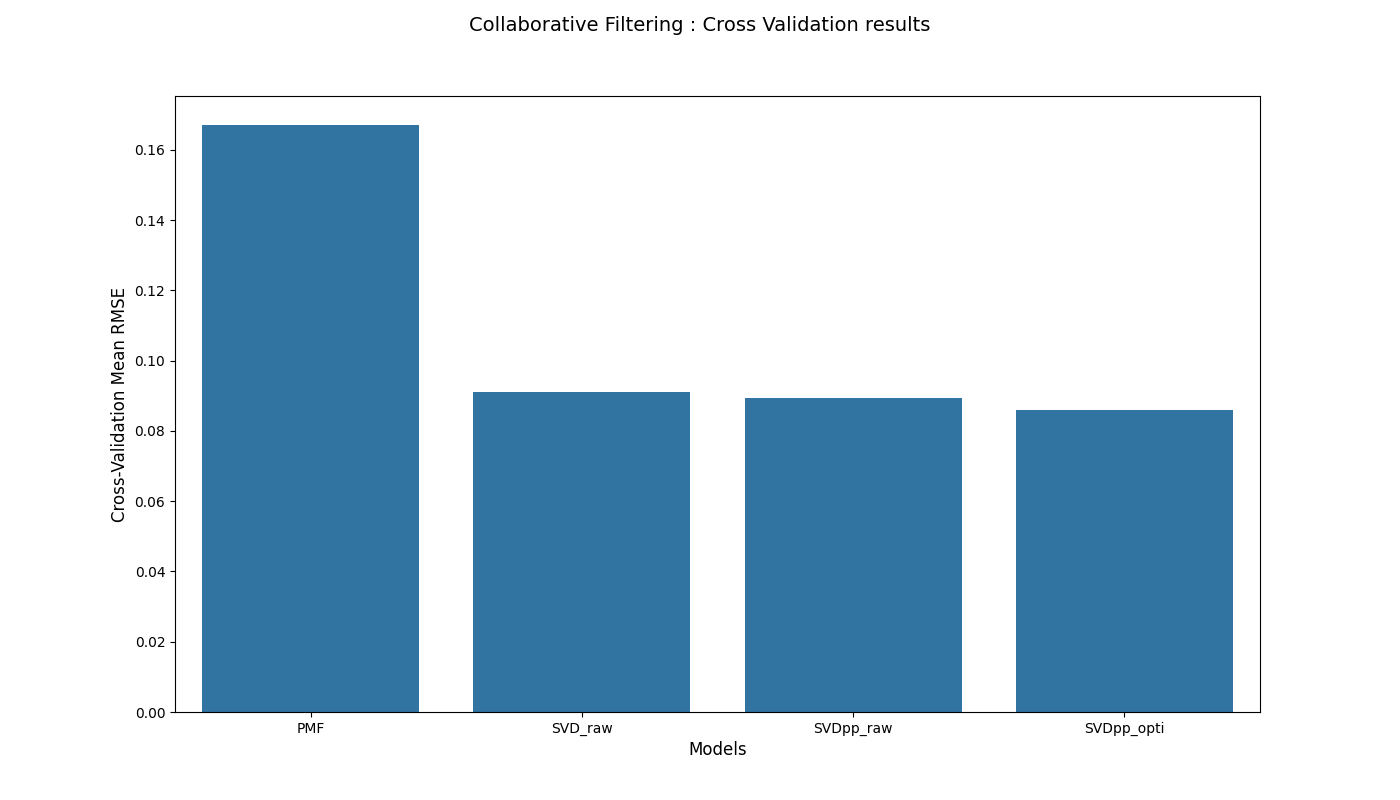

In [51]:
# plot RMSE results
if "cf_cv_results.png" not in os.listdir("mySaves/images/plots") :
    # create figure
    fig = plt.figure(figsize=(14,8))
    # plot
    sns.barplot(data=cf_results, y="mean_RMSE_CV", x='model_name')
    # title
    fig.suptitle("Collaborative Filtering : Cross Validation results", fontsize=14)
    # labels
    plt.xlabel("Models", fontsize=12)
    plt.ylabel("Cross-Validation Mean RMSE", fontsize=12)
    # save
    fig.savefig("mySaves/images/plots/cf_cv_results.png")
    plt.show()
else :
    # load image
    display(Image.open("mySaves/images/plots/cf_cv_results.png"))

In [52]:
# save results
dump(cf_results, "mySaves/cf_results/cf_results.joblib")

['mySaves/cf_results/cf_results.joblib']

Nous partons sur le modèle `SVDpp`.

## 1.4. <a id='toc4_4_'></a>[Tester le modèle](#toc0_)

Entraînons le modèle SVDpp sur l'ensemble des données :

In [53]:
# train SVDpp on X_cf_surprise
if "collab_model.joblib" not in os.listdir("mySaves/dev_files") :
    # get best parameters
    best_parameters = cf_results.loc[cf_results["model_name"]=="SVDpp_opti", "parameters"].values[0]
    # initiate model
    model = SVDpp(**best_parameters)
    # use custom function "fit_and_save"
    mf.fit_and_save(
        X_surprise=X_cf_surprise, 
        model_surprise=model,
        path="mySaves/dev_files/collab_model.joblib")
else :
    # load existing trained model
    model = load("mySaves/dev_files/collab_model.joblib")


Nous pouvons tester notre modèle de recommandation. Pour cela nous avons créé une fonction `cf_top_5` qui, à partir d'un `user_id`, d'un modèle `surprise` et d'un dataframe `X` :
- filtre `X` sur le `user_id`
- extrait les articles qu'il n'a jamais lu
- crée un dataframe `anti_X` avec les colonnes :
    - `user_id`, avec toujours la même valeur, notre utilisateur
    - `article_id`, avec les articles qu'il n'a jamais lu
    - `rating_id`, avec toujours la même valeur également (car pour rappel ces ratings n'existent pas)
- transforme ce dataframe en `testset` `surprise`
- effectue des prédictions avec le modèle donné
- utilise la fonction `get_top_n` (https://surprise.readthedocs.io/en/stable/FAQ.html)
- sort la liste des 5 ratings prédits les plus élevés

In [54]:
# test for some users
for i in range(10) :
    user_id = X_cf["user_id"].sample(1, random_state=i).values[0]
    print(
        f'For user {user_id} :', 
        mf.cf_top_5(
            user_id=user_id, 
            data_cf=X_cf, 
            trained_model=model
            )
        )

For user 172838 : [96210, 234698, 336221, 352094, 331116]
For user 132915 : [166072, 342030, 211484, 32730, 293429]
For user 115205 : [331587, 289283, 118858, 4400, 70682]
For user 93053 : [331116, 96210, 265168, 234698, 183176]
For user 254589 : [96210, 331116, 183176, 234698, 336245]
For user 86052 : [351876, 331116, 96210, 183176, 234698]
For user 146555 : [332125, 355179, 255947, 172761, 279904]
For user 42159 : [257972, 288794, 160253, 342380, 348129]
For user 245242 : [314181, 111338, 96210, 354580, 261633]
For user 147378 : [255747, 352683, 4729, 96690, 42622]


## 1.5. <a id='toc4_5_'></a>[Modèle plus léger pour le test de production](#toc0_)

Pour le test de la **mise en production** :
- afin de réduire l'espace mémoire utilisé, nous allons **entraîner** un modèle sur les interactions d'une **sélection de 100 000 utilisateurs**
- afin d'alléger l'interface utilisateur, nous donnerons accès à **une centaine** de `user_id`s, permettant de tester le modèle

In [55]:
# select 100000 users
if "kept_user_ids.joblib" not in os.listdir("mySaves/dev_files") :
    seed = np.random.seed(16)
    kept_user_ids = np.random.choice(
        X_cf["user_id"].cat.categories, 
        size=100000,
        )
    # save
    dump(kept_user_ids, "mySaves/dev_files/kept_user_ids.joblib")
    # save some users only for testing in production
    dump(kept_user_ids[:100], "mySaves/prod_files/test_list_user_ids.joblib")
else :
    kept_user_ids = load("mySaves/dev_files/kept_user_ids.joblib")

Nous pouvons maintenant créer notre dataframe `user_id`, `article_id`, `rating` dans une version allégée, avec seulement ces utilisateurs :

In [56]:
# use custom function to create a dataframe for surprise
if "X_cf_light.joblib" not in os.listdir("mySaves/dev_files") :
    X_cf_light = mf.read_clicks_and_prepare_rating(
        clicks_folder_path=clicks_folder_path,  
        ref_date_for_seniority=datetime.datetime(year=2017, month=10, day=18),
        kept_user_ids = kept_user_ids,
        min_seniority=0,
        max_seniority=None,
        minimum_count=10,
        min_count_for_best=1000
        )

    # save
    dump(X_cf_light, "mySaves/dev_files/X_cf_light.joblib")

else :
    # load
    X_cf_light = load("mySaves/dev_files/X_cf_light.joblib")


# create a surprise dataset
# create reader with rating scale from 0 to 1
reader = Reader(rating_scale=(0,1))
# create Dataset
X_cf_light_surprise = Dataset.load_from_df(X_cf_light, reader=reader)

Et créer un modèle plus léger :

In [57]:
# train SVDpp on X_cf_light_surprise
if "collab_model_light.joblib" not in os.listdir("mySaves/prod_files") :
    # get best parameters
    best_parameters = cf_results.loc[cf_results["model_name"]=="SVDpp_opti", "parameters"].values[0]
    # initiate model
    light_model = SVDpp(**best_parameters)
    # use custom function "fit_and_save"
    mf.fit_and_save(
        X_surprise=X_cf_light_surprise, 
        model_surprise=light_model,
        path="mySaves/prod_files/collab_model_light.joblib")
else :
    # load existing trained model
    light_model = load("mySaves/prod_files/collab_model_light.joblib")

Nous pouvons tester notre modèle léger de recommandation :

In [58]:
# test for some users
for i in range(10) :
    user_id = X_cf_light["user_id"].sample(1, random_state=i).values[0]
    print(
        f'For user {user_id} :', 
        mf.cf_top_5(
            user_id=user_id, 
            data_cf=X_cf_light, 
            trained_model=light_model
            )
        )

For user 7432 : [300007, 256756, 175279, 59219, 195428]
For user 1607 : [195842, 96210, 234698, 336221, 15755]
For user 269236 : [288456, 358109, 16093, 225745, 234698]
For user 9869 : [76408, 96210, 270539, 234698, 336221]
For user 35602 : [96987, 271914, 187215, 96210, 336221]
For user 237956 : [19786, 341225, 360644, 140524, 362272]
For user 224043 : [176910, 330894, 114575, 234698, 336221]
For user 129347 : [234698, 96210, 336221, 254414, 331116]
For user 101579 : [330770, 49034, 234698, 96210, 336221]
For user 66077 : [285642, 48460, 96210, 160981, 336964]


# 2. <a id='toc5_'></a>[MODÉLISATION *CONTENT BASE*](#toc0_)

Nous pouvons passer à la recommandation de type *Content Base*. 

Celle-ci :
- sera principalement basée sur les ***embeddings*** des articles lus par l'utilisateur
- et intégrera également un filtre préalable sur les **catégories principales** parcourues par celui-ci

## 2.1. <a id='toc5_1_'></a>[Préparer les données](#toc0_)

Commençons par charger les données `clicks` et `articles_metadata` dans un seul dataframe :

In [59]:
# load, prepare and merge "clicks" and "articles_metadata" CSVs
if "data_cb.joblib" not in os.listdir("mySaves/dev_files") :
    # necessary columns
    clicks_usecols = [
        'user_id', 
        'click_article_id', 
        'click_timestamp',
        ]
    meta_usecols = [
        'article_id', 
        'category_id'
    ]

    # unnecessary columns (only used for preparation (sorting) and merging)
    drop_after_prep_cols = [
        "click_article_id", 
        # "click_timestamp"
    ]

    # use custom function
    data_cb = mf.read_clicks_and_meta(
        clicks_folder_path=clicks_folder_path,
        meta_path=meta_path,
        clicks_usecols=clicks_usecols,
        meta_usecols=meta_usecols,
        drop_after_prep_cols=drop_after_prep_cols
        )

    # save
    dump(data_cb, "mySaves/dev_files/data_cb.joblib")

else :
    data_cb = load("mySaves/dev_files/data_cb.joblib")

data_cb

,user_id,click_timestamp,article_id,category_id
0,320431,2017-11-13 20:04:14.886,145309,269
1,320431,2017-11-13 20:03:44.886,203538,327
2,252642,2017-11-07 22:31:52.860,96333,209
3,252642,2017-11-07 22:31:22.860,207672,331
4,201738,2017-11-04 12:27:02.502,224148,354
...,...,...,...,...
2950705,70,2017-10-01 03:00:18.863,119592,247
2950706,111,2017-10-01 03:00:14.140,202436,327
2950707,154,2017-10-01 03:00:04.207,96663,209
2950708,79,2017-10-01 03:00:01.702,159359,281


## 2.2. <a id='toc5_2_'></a>[Obtenir les catégories principales de l'utilisateur](#toc0_)

Nous avons rédigé une fonction `get_user_top2_categories_and_list_of_ids`.

L'idée est d'isoler les catégories "préférées du moment" de l'utilisateur. Pour essayer d'approcher cela, nous nous basons sur :
- le fait que les articles de la catégorie aient été **lus récemment**
- le **nombre d'articles** lus appartenant à la catégorie

Nous faisons également le **choix de considérer 2 catégories** (ou 1 seule si l'utilisateur n'a lu au sein que d'une seule catégorie).

La fonction prend en **arguments** un `user_id` et `data_cb`, le dataframe ci-dessus, et **retourne** un **dictionnaire** avec :
- comme clés, nos 2 *category_id*s
- comme valeurs, les liste d'`article_id`s associés


Voyons ce que cela donne avec un exemple :

In [60]:
# pick a user
np.random.seed(seed=6)
test_user_id = np.random.choice(kept_user_ids, size=1)[0]
test_user_id

203083

In [61]:
# test custom function get_user_top2_categories_and_list_of_ids
test_user_dict = mf.get_user_top2_categories_and_list_of_ids(
    data_cb=data_cb, 
    user_id=test_user_id)

test_user_dict

{127: [62701, 62464, 62675], 136: [71542]}

## 2.3. <a id='toc5_3_'></a>[Filtrer les embeddings sur les catégories principales](#toc0_)

Pour chaque *category_id* sélectionné, nous filtrons le fichier d'*embeddings*, pour ne conserver que ceux des articles appartenant à cette catégorie. Pour cela nous avons rédigé la fonction `get_cat_embeddings`, qui prend en entrée :
- les catégories `cat_ids_list`
- un *embedding* `emb`
- un dataframe des *articles_metadata* `meta`

La fonction retourne également un dictionnaire, mais cette fois les valeurs sont les ***embeddings* filtrés**.

In [62]:
# extract the 2 categories
test_cats = list(test_user_dict.keys())
# load "articles_metadata.csv" only with "article_id", "category_id" columns
# use custom function "read_meta"
if "meta_cb.joblib" not in os.listdir("mySaves/prod_files") :
    meta_cb = mf.read_meta(meta_path, usecols = ["article_id", "category_id"]).astype(int)
    # save
    dump(meta_cb, "mySaves/prod_files/meta_cb.joblib")
else :
    meta_cb = load("mySaves/prod_files/meta_cb.joblib")
# test custom function "get_cat_embeddings"
test_embs = mf.get_cat_embeddings(
    cat_ids_list=test_cats, 
    emb = emb_reduced,
    meta = meta_cb
    )

test_embs

{127:              0         1         2         3         4         5         6   \
 61865  7.576358  2.534658  4.392003  0.862846 -5.170998 -4.608817 -1.094802   
 61866  2.293916  0.127101  1.570541  2.241727 -1.686441  3.263310 -0.821275   
 61867  4.220024  2.267296  2.339798 -2.435086 -3.593882 -2.300511 -0.806614   
 61868  7.555596  1.069995  4.057072  0.957219 -2.581642 -0.263557 -0.501203   
 61869  7.466855  2.048302  3.941885 -1.471380 -4.417357 -0.861462  0.983991   
 ...         ...       ...       ...       ...       ...       ...       ...   
 62788  9.685449 -1.962937  2.115432 -1.130606 -5.548280 -4.446809 -0.864685   
 62789  2.888261 -2.032840  0.595348 -2.511675  1.076206  2.888155 -2.792193   
 62790  3.986691 -1.145274  4.728462 -3.207933  2.231805  1.706199 -3.357298   
 62791  2.033399  1.931885  1.319022  0.080482 -4.247724  0.306637 -1.358061   
 62792  2.149336 -4.426373  5.088209 -6.392074  1.616551  0.976085  1.284007   
 
              7         8        

## 2.4. <a id='toc5_4_'></a>[Obtenir 5 recommendations d'articles](#toc0_)

Grâce à ces 2 dictionnaires, nous obtenons nos 5 recommandations : 3 pour la première catégorie, 2 pour la deuxième. Pour cela nous avons rédigé la fonction  `get_5_content_base_reco_from_dicts`, qui :
- pour chaque catégorie
- filtre les embeddings de la catégorie sur les articles DÉJÀ lus par l'utilisateur
- synthétise ces embeddings en les moyennant
- isole également les embeddings, toujours de cette catégorie, correspondant aux articles n'ayant PAS été lus
- calcule la `cosine_similarity` entre l'embedding synthétique des articles lus et les embeddings des articles non lus
- récupère les "article_id"s avec les meilleurs scores (3 pour la première catégorie, 2 pour la deuxième)

In [63]:
# test custom function "get_5_content_base_reco_from_dicts"
print(
    f'For user {test_user_id} :',
    mf.get_5_content_base_reco_from_dicts(
        user_dict=test_user_dict, 
        emb_dict=test_embs
        )
)


For user 203083 : [62416, 62166, 62569, 66950, 66523]


## 2.5. <a id='toc5_5_'></a>[Modèle final](#toc0_)

Nous synthétisons ces différentes étapes dans une fonction unique `cb_top_5`. Celle-ci prend alors en entrée un `user_id`, nos données clicks `data_cb`, un array d'embeddings `emb` et un dataframe des *articles_metadata* `meta` :

In [64]:
# use custom function "cb_top_5" on our test user_id
print(
    f'For user {test_user_id} :',
    mf.cb_top_5(
        user_id=test_user_id,
        data_cb=data_cb, 
        emb=emb_reduced,
        meta=meta_cb
    )
)

For user 203083 : [62416, 62166, 62569, 66950, 66523]


## 2.6. <a id='toc5_6_'></a>[Quel impact de la réduction ACP des *embeddings* initiaux sur les résultats ?](#toc0_)

Nous pouvons comparer le résultat en fonction du fichier d'embeddings :
- la version initiale
- la version légère (suite à la réduction ACP)

Pour cela nous comparerons les recommandations obtenues (le **nombre d'"article_id"s en communs**) pour quelques échantillons :

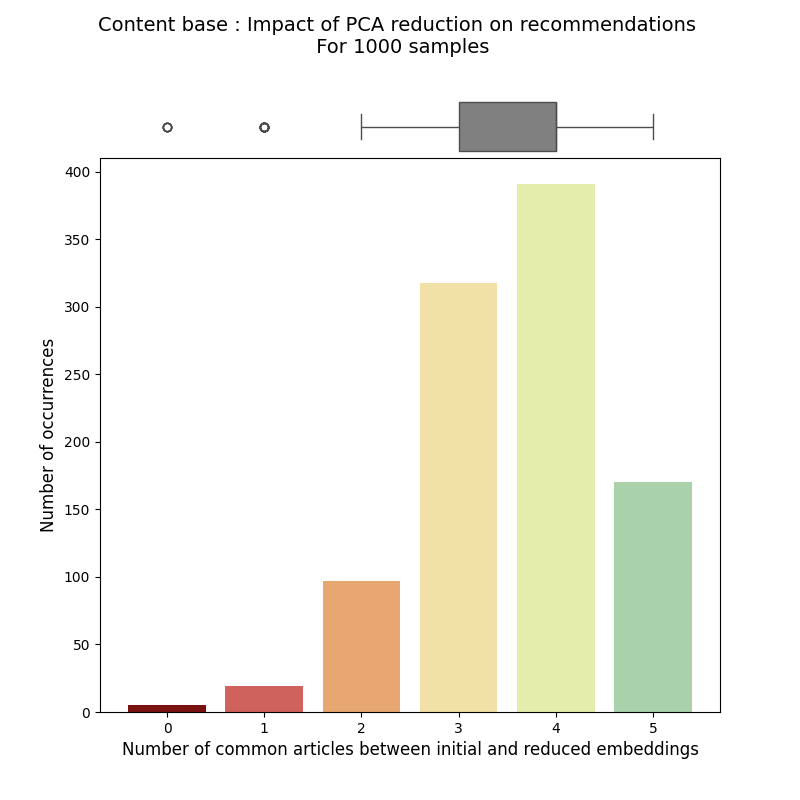

In [65]:
# compare content base recommendations for some samples 
if "embedding_comparison_for_content_base.png" not in os.listdir("mySaves/images/plots") :

    # pick "user_id" samples
    np.random.seed(seed=16)
    test_user_ids = np.random.choice(data_cb["user_id"].unique(), 1000)

    # initiate a Series to store the number of common "article_id"s between :
    # - recommendations obtained from initial embeddings file 
    # - recommendations obtained from reduced (with PCA) embedding file
    number_of_common_recs_Series = pd.Series(index=test_user_ids, name="number_of_common_articles")

    # load full embedding
    emb_large = pd.read_pickle(emb_path)

    # for each user
    for user_id in test_user_ids :
        # get recs from "emb_reduced"
        rec_light = mf.cb_top_5(
            user_id=user_id,
            data_cb=data_cb, 
            emb=emb_reduced,
            meta=meta_cb
        )
        # get recs from original "articles_embeddings"
        rec_full = mf.cb_top_5(
            user_id=user_id,
            data_cb=data_cb, 
            emb=emb_large,
            meta=meta_cb
        )
        # compute the number of common articles
        number_of_common_recs = len(
            set(rec_light).intersection(set(rec_full))
        )
        # add to Series
        number_of_common_recs_Series[user_id] = number_of_common_recs

    # plot
    # create figure
    fig, (ax_box, ax_count) = plt.subplots(2, 1, figsize=(8,8), height_ratios=(0.1,0.9), sharex=True)
    plt.subplots_adjust(hspace=0)
    # plot
    sns.countplot(
        x=number_of_common_recs_Series.astype(int), 
        ax=ax_count, 
        palette = ["darkred"]+sns.color_palette("Spectral")[:-1],
        )
    sns.boxplot(x=number_of_common_recs_Series.astype(int), ax=ax_box, color="gray")
    # title
    fig.suptitle("Content base : Impact of PCA reduction on recommendations \n For 1000 samples", fontsize=14)
    # remove box plot axis
    ax_box.axis(False)
    # labels
    ax_count.set_xlabel("Number of common articles between initial and reduced embeddings", fontsize=12)
    ax_count.set_ylabel("Number of occurrences", fontsize=12)
    # save
    fig.savefig("mySaves/images/plots/embedding_comparison_for_content_base.png")
    plt.show()
else :
    # load image
    display(Image.open("mySaves/images/plots/embedding_comparison_for_content_base.png"))


Les recommendations sont globalement similaires.

## 2.7. <a id='toc5_7_'></a>[Modèle final léger pour le test en production](#toc0_)

Pour le test de mise en production, nous n'utiliserons pour rappel que des utilisateurs appartenant à `kept_user_ids`. Nous pouvons donc utiliser des données clicks moins volumineuses :

In [66]:
# build a light data_cb
# load, prepare and merge "clicks" and "articles_metadata" CSVs
if "data_cb_light.joblib" not in os.listdir("mySaves/dev_files") :
    # necessary columns
    clicks_usecols = [
        'user_id', 
        'click_article_id', 
        'click_timestamp',
        ]
    meta_usecols = [
        'article_id', 
        'category_id'
    ]

    # unnecessary columns (only used for preparation (sorting) and merging)
    drop_after_prep_cols = [
        "click_article_id", 
        # "click_timestamp"
    ]

    # use custom function

    data_cb_light = mf.read_clicks_and_meta(
        clicks_folder_path=clicks_folder_path,
        meta_path=meta_path,
        kept_user_ids=kept_user_ids,
        clicks_usecols=clicks_usecols,
        meta_usecols=meta_usecols,
        drop_after_prep_cols=drop_after_prep_cols
        )

    # save
    dump(data_cb_light, "mySaves/dev_files/data_cb_light.joblib")

else :
    data_cb_light = load("mySaves/dev_files/data_cb_light.joblib")

In [67]:
# use custom function "cb_top_5" on our test user_id
mf.cb_top_5(
    user_id=test_user_id,
    data_cb=data_cb_light, 
    emb=emb_reduced,
    meta=meta_cb
)

[62416, 62166, 62569, 66950, 66523]

# 3. <a id='toc6_'></a>[MIXER LES DEUX TYPES DE RECOMMANDATION](#toc0_)

Nous pouvons mixer les deux approches en combiant les deux fonction `cf_top_5` et `cb_top_5`.

Afin de rationaliser les paramètres d'entrée, nous effectuerons une jointure entre nos dataframe des données *clicks* (`X_cf_light` et `data_cb`). Cela aura pour conséquence de modifier certaines recommendations pour la partie *Content Base*.

(Pour rappel, nous avions effectué un filtre sur les données *Collaborative Filtering*, avec un nombre minimal d'apparitions des articles, avec le paramètre `minimum_count`. Certains articles n'apparaîtreront donc plus pour la partie *Content Base* après la fusion)

In [68]:
# merge "cf" data et "cb" data
if "data_light.joblib" not in os.listdir("mySaves/prod_files") :
    # filter "data_cb_light" on articles contained in "X_cf_light"
    mask = data_cb_light["article_id"].isin(X_cf_light["article_id"].unique())
    data_light = data_cb_light.loc[mask]
    # merge
    # (If "on" is None and not merging on indexes then this defaults to the intersection of the columns in both DataFrames.)
    data_light = data_light.merge(X_cf_light, how="inner", on=None)
    # save
    dump(data_light, "mySaves/prod_files/data_light.joblib")

else :
    data_light = load("mySaves/prod_files/data_light.joblib")

data_light

,user_id,click_timestamp,article_id,category_id,rating
0,317399,2017-10-19 16:24:07.392,336587,437,0.075264
1,317399,2017-10-19 16:23:39.704,285849,412,0.212186
2,215206,2017-10-18 07:48:09.240,285642,412,0.031609
3,20310,2017-10-17 21:32:04.795,285642,412,0.027188
4,82782,2017-10-17 20:51:55.181,285642,412,0.028066
...,...,...,...,...,...
740272,154,2017-10-01 03:00:34.207,108854,230,0.000000
740273,79,2017-10-01 03:00:31.702,205897,331,0.000000
740274,70,2017-10-01 03:00:18.863,119592,247,0.000000
740275,154,2017-10-01 03:00:04.207,96663,209,0.000000


La fonction `cf_and_cb_mix_top_5` est donc un mix entre `cf_top_5` et `cb_top_5`. Afin de rester sur notre objectif de **5 recommandations**, nous rajoutons un paramètre `n_cf` qui correspond au nombre d'articles à conserver de la prédiction par *Collaborative Filtering*.

In [69]:
# test a mix of collaborative filtering and content base

# number of recommendations from collaborative filtering
n_cf = 3
# collaborative filtering model
cf_top_5 = mf.cf_top_5(
    user_id=test_user_id, 
    data_cf=data_light[["user_id", "article_id", "rating"]], 
    trained_model=light_model,
)
print(f'Recommendations for user {test_user_id} :')
print("Collaborative filtering :", cf_top_5)
# content base model
cb_top_5 = mf.cb_top_5(
    user_id=test_user_id, 
    data_cb=data_light[["user_id", "click_timestamp", "article_id", "category_id"]], 
    emb=emb_reduced,
    meta=meta_cb
)
print("Content base :", cb_top_5)
# use new custom function "cf_and_cb_mix_top_5"
mix_top_5 = mf.cf_and_cb_mix_top_5(
    user_id=test_user_id, 
    n_cf=n_cf,
    data=data_light, 
    trained_model=load("mySaves/prod_files/collab_model_light.joblib"),
    emb=emb_reduced,
    meta=meta_cb
)
print(f"Hybrid model ({n_cf} from CF, {5-n_cf} from CB) :", mix_top_5)

Recommendations for user 203083 :
Collaborative filtering : [144979, 119066, 142086, 289203, 234698]
Content base : [62416, 62166, 62569, 66950, 66523]
Hybrid model (3 from CF, 2 from CB) : [144979, 119066, 142086, 62416, 62166]
